In [45]:
from sklearn.utils import class_weight
from scipy import interpolate
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
import numpy as np
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import torch
from torch import Tensor
import torch.nn as nn
# from _internally_replaced_utils import load_state_dict_from_url
from typing import Type, Any, Callable, Union, List, Optional
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torch.optim as optim
import torchvision.models as models
import torch.distributed as dist
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score
import time
import os
from tqdm import tqdm_notebook


In [46]:

device = torch.device('cuda' if torch.cuda.is_available()
                      else 'cpu')  
print(device)

cuda


# Set up the dataset

In [142]:
data = pd.read_csv('e:/xunleidownload/train.csv')
class dataset(Dataset):
    
    def __init__(self, df, data_path, image_transform=None, train=True):
        super(Dataset, self).__init__()
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image_id = self.df['id_code'][index]
        image = Image.open(f'{self.data_path}/{image_id}.png')
        if self.image_transform:
            image = self.image_transform(image)

        if self.train:
            label = self.df['diagnosis'][index]
            return image, label

        else:
            return image


image_transform = transforms.Compose([transforms.Resize([224, 224]),
                                      transforms.ToTensor(),
                                      torchvision.transforms.RandomHorizontalFlip(
                                          p=0.5),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])  
data_set = dataset(data, f'd:/train_images', image_transform=image_transform)
train_set, valid_set = torch.utils.data.random_split(data_set, [3302, 360])




# Model architecture

In [179]:
class ChannelAttention(nn.Module):
    """ Squeeze-and-Excitation block """
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class SpatialAttention(nn.Module):
    """ Spatial Attention Block """
    
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        
        x = self.conv1(x)
        
        return x * self.sigmoid(x)

class ResNet18WithAttention(nn.Module):
    def __init__(self, num_classes=5):
        super(ResNet18WithAttention, self).__init__()
        
        self.base_model = models.resnet18(pretrained=True)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)
        
        self.channel_attention = ChannelAttention(self.base_model.layer4[-1].conv2.out_channels)
        self.spatial_attention = SpatialAttention()
        
    def forward(self, x):
        x = self.base_model.conv1(x)
        x = self.base_model.bn1(x)
        x = self.base_model.relu(x)
        x = self.base_model.maxpool(x)

        x = self.base_model.layer1(x)
        
        x = self.base_model.layer2(x)
        x = self.base_model.layer3(x)
        x = self.base_model.layer4(x)
        
        
        
        x = self.channel_attention(x)
        attention_map = self.spatial_attention(x)
        x = x*attention_map.expand_as(x)
       
        x = self.base_model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.base_model.fc(x)
        return x
    
class ResNet34WithAttention(nn.Module):
    def __init__(self, num_classes=5):
        super(ResNet34WithAttention, self).__init__()
        
        self.base_model = models.resnet34(pretrained=True)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)
        
        self.channel_attention = ChannelAttention(self.base_model.layer4[-1].conv2.out_channels)
        self.spatial_attention = SpatialAttention()
        
    def forward(self, x):
        x = self.base_model.conv1(x)
        x = self.base_model.bn1(x)
        x = self.base_model.relu(x)
        x = self.base_model.maxpool(x)

        x = self.base_model.layer1(x)
        x = self.base_model.layer2(x)
        x = self.base_model.layer3(x)
        x = self.base_model.layer4(x)
        x = self.channel_attention(x)
        attention_map = self.spatial_attention(x)
        x = x*attention_map.expand_as(x)
        
        
        x = self.base_model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.base_model.fc(x)
        return x

class ResNet50WithAttention(nn.Module):
    def __init__(self, num_classes=5):
        super(ResNet50WithAttention, self).__init__()
        
        self.base_model = models.resnet50(pretrained=True)
        
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)
        
        
        self.channel_attention = ChannelAttention(self.base_model.layer4[-1].conv3.out_channels)
        self.spatial_attention = SpatialAttention()
        
    def forward(self, x):
        x = self.base_model.conv1(x)
        x = self.base_model.bn1(x)
        x = self.base_model.relu(x)
        x = self.base_model.maxpool(x)

        x = self.base_model.layer1(x)
        x = self.base_model.layer2(x)
        x = self.base_model.layer3(x)
        x = self.base_model.layer4(x)

       
        x = self.channel_attention(x)
        attention_map = self.spatial_attention(x)
        x = x*attention_map.expand_as(x)

        x = self.base_model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.base_model.fc(x)
        return x

# Load and set the model

In [180]:

model = ResNet50WithAttention()

d:\Anaconda\envs\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\envs\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [189]:
checkpoint = torch.load('c:/Users/86182/Desktop/Deep Learning/50/model_epoch_9.pth')


model_state_dict = checkpoint['model_state_dict']  


model.load_state_dict(model_state_dict)
model.to(device)
model.eval()

ResNet34WithAttention(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

# Show the confusion matrix of the model

100 100 100 100 100
accuracy 85.2
[[98  2  0  0  0]
 [ 1 90  7  1  1]
 [ 2  8 75 14  1]
 [ 0  1  6 91  2]
 [ 0  3 10 15 72]]
    0   1   2   3   4
0  98   2   0   0   0
1   1  90   7   1   1
2   2   8  75  14   1
3   0   1   6  91   2
4   0   3  10  15  72
   severity  True Positive  False Negative  False Positive  True Negative  \
0         0             98               2               3            402   
1         1             90              10              14            410   
2         2             75              25              23            425   
3         3             91               9              30            409   
4         4             72              28               4            428   

   Precision  Recall  F1-score  
0   0.970297    0.98  0.975124  
1   0.865385    0.90  0.882353  
2   0.765306    0.75  0.757576  
3   0.752066    0.91  0.823529  
4   0.947368    0.72  0.818182  


C:\Users\86182\AppData\Local\Temp\ipykernel_17796\2500634537.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  FP = cm_df.sum(axis=0)[i] - arr[:][i][i]


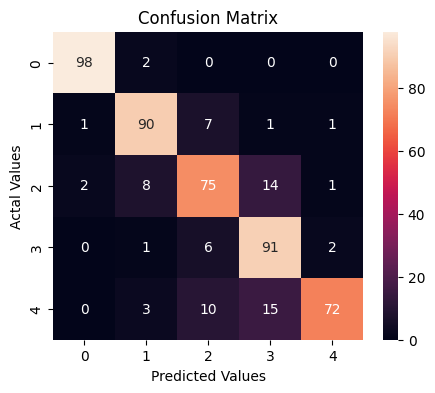

In [190]:
results = []
i = 0
j = 0
k = 0
l = 0
m = 0
for x, y in DataLoader(data_set):
    if (y.numpy()[0] == 0 and i < 100):
        result = model(x.to(device)).argmax(dim=1).cpu().detach()
        results.append((result.numpy()[0], y.numpy()[0]))
        i = i+1
    if (y.numpy()[0] == 1 and j < 100):
        result = model(x.to(device)).argmax(dim=1).cpu().detach()
        results.append((result.numpy()[0], y.numpy()[0]))
        j = j+1
    if (y.numpy()[0] == 2 and k < 100):
        result = model(x.to(device)).argmax(dim=1).cpu().detach()
        results.append((result.numpy()[0], y.numpy()[0]))
        k = k+1
    if (y.numpy()[0] == 3 and l < 100):
        result = model(x.to(device)).argmax(dim=1).cpu().detach()
        results.append((result.numpy()[0], y.numpy()[0]))
        l = l+1
    if (y.numpy()[0] == 4 and m < 100):
        result = model(x.to(device)).argmax(dim=1).cpu().detach()
        results.append((result.numpy()[0], y.numpy()[0]))
        m = m+1
    if(i+j+k+l+m >= 500):
        break

    
print(i, j, k, l, m)


labelis = [val[1] for val in results]
predis = [val[0] for val in results]
count = 0
for x, y in results:
    if x == y:
        count += 1
cm = confusion_matrix(labelis, predis, labels=[0, 1, 2, 3, 4])
print('accuracy', 100*(count)/len(predis))
print(cm)

cm_df = pd.DataFrame(cm,
                     index=['0', '1', '2', '3', '4'],
                     columns=['0', '1', '2', '3', '4'])
print(cm_df)

total = sum(cm_df.sum(axis=1))

arr = np.array(cm_df)
cnfm = []
for i in range(0, 5):
    TP = arr[:][i][i]
    FN = sum(arr[:][i]) - arr[:][i][i]
    FP = cm_df.sum(axis=0)[i] - arr[:][i][i]
    TN = total - TP
    precision = TP / (TP+FP)
    recall = TP/(TP+FN)
    f1 = 2*precision*recall/(precision+recall)
    cnfm.append([i, TP, FN, FP, TN, precision, recall, f1])
f1_result = pd.DataFrame(cnfm, columns=['severity', 'True Positive', 'False Negative',
                         'False Positive', 'True Negative', 'Precision', 'Recall', 'F1-score'])
print(f1_result)


plt.figure(figsize=(5, 4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

# Test stage of the model

[0.     0.     0.     0.005  0.005  0.0275 0.0275 0.0325 0.0325 0.265
 0.27   0.3875 0.3925 0.5    0.505  0.6925 1.    ]
[0.   0.01 0.97 0.97 0.98 0.98 0.99 0.99 1.   1.   1.   1.   1.   1.
 1.   1.   1.  ]
[0.     0.     0.     0.     0.     0.     0.     0.0025 0.0025 0.005
 0.005  0.0075 0.0075 0.01   0.01   0.0125 0.0125 0.015  0.015  0.0175
 0.0175 0.03   0.03   0.0375 0.0375 0.0425 0.0425 0.05   0.05   0.055
 0.055  0.7325 1.    ]
[0.   0.01 0.04 0.06 0.24 0.26 0.29 0.29 0.56 0.56 0.74 0.74 0.75 0.75
 0.87 0.87 0.9  0.9  0.91 0.91 0.92 0.92 0.94 0.94 0.95 0.95 0.96 0.96
 0.97 0.97 0.98 0.98 1.  ]
[0.     0.     0.0025 0.0025 0.005  0.005  0.0075 0.0075 0.01   0.01
 0.0125 0.0125 0.015  0.015  0.0175 0.0175 0.02   0.02   0.025  0.025
 0.0275 0.0275 0.03   0.03   0.035  0.035  0.0375 0.0375 0.045  0.045
 0.075  0.075  0.1    0.1    0.1225 0.1225 0.2125 0.2125 0.27   0.275
 0.2775 0.2775 0.3425 0.3475 0.3875 0.3875 0.4725 0.4775 0.9875 1.    ]
[0.   0.01 0.01 0.11 0.11 0.47 0.47 0.5

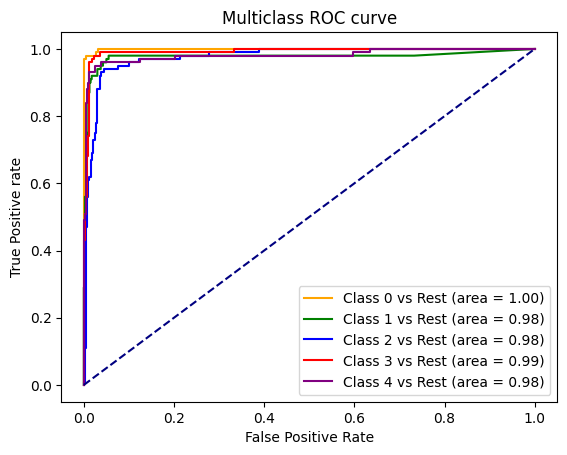

In [183]:
def test_class_probabilities(model, test_loader):
    model.eval()
    actuals = []
    probabilities = []
    i = 0
    j = 0
    k = 0
    l = 0
    f = 0
    with torch.no_grad():
        for x, y in test_loader:
            y = y.numpy()[0]
            outputs = model(x.to(device))
            prediction = outputs.argmax(dim=1, keepdim=True).cpu().detach()
            if (y == 0 and i < 100):
                actuals.append(y)
                values = outputs.cpu().detach().numpy()[0]
                m = -1*min(values)
                values = [val+m for val in values]
                prob = values/sum(values)
                probabilities.append(np.exp(prob))
                i = i+1
            if (y == 1 and j < 100):
                actuals.append(y)
                values = outputs.cpu().detach().numpy()[0]
                m = -1*min(values)
                values = [val+m for val in values]
                prob = values/sum(values)
                probabilities.append(np.exp(prob))
                j = j+1
            if (y == 2 and k < 100):
                actuals.append(y)
                values = outputs.cpu().detach().numpy()[0]
                m = -1*min(values)
                values = [val+m for val in values]
                prob = values/sum(values)
                probabilities.append(np.exp(prob))
                k = k+1
            if (y == 3 and l < 100):
                actuals.append(y)
                values = outputs.cpu().detach().numpy()[0]
                m = -1*min(values)
                values = [val+m for val in values]
                prob = values/sum(values)
                probabilities.append(np.exp(prob))
                l = l+1
            if (y == 4 and f < 100):
                actuals.append(y)
                values = outputs.cpu().detach().numpy()[0]
                m = -1*min(values)
                values = [val+m for val in values]
                prob = values/sum(values)
                probabilities.append(np.exp(prob))
                f = f+1
            if(i+j+k+l+f >= 500):
                break
    return actuals, probabilities


# show the curve of ROC
def plot_roc(actuals,  probabilities):

    fpr = {}
    tpr = {}
    thresh = {}
    roc_auc = {}
    n_class = 5

    for i in range(n_class):
        fpr[i], tpr[i], thresh[i] = roc_curve(
            actuals, [val[i] for val in probabilities], pos_label=i)
        print(fpr[i])
        print(tpr[i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # plotting
    plt.plot(fpr[0], tpr[0], linestyle='-', color='orange',
             label="Class 0 vs Rest (area = %0.2f)" % roc_auc[0])
    plt.plot(fpr[1], tpr[1], linestyle='-', color='green',
             label="Class 1 vs Rest (area = %0.2f)" % roc_auc[1])
    plt.plot(fpr[2], tpr[2], linestyle='-', color='blue',
             label="Class 2 vs Rest (area = %0.2f)" % roc_auc[2])
    plt.plot(fpr[3], tpr[3], linestyle='-', color='red',
             label="Class 3 vs Rest (area = %0.2f)" % roc_auc[3])
    plt.plot(fpr[4], tpr[4], linestyle='-', color='purple',
             label="Class 4 vs Rest (area = %0.2f)" % roc_auc[4])
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')


act, prob = test_class_probabilities(model, DataLoader(data_set))

plot_roc(act, prob)
print(act)

In [95]:
import numpy as np
train_acc=np.load('c:/Users/86182/Desktop/Deep Learning/18/train_acc.npy')
train_losses=np.load('c:/Users/86182/Desktop/Deep Learning/18/train_losses.npy')
valid_acc=np.load('c:/Users/86182/Desktop/Deep Learning/18/valid_acc.npy')
valid_losses=np.load('c:/Users/86182/Desktop/Deep Learning/18/valid_losses.npy')


# Show the curve of training and validation accuracy

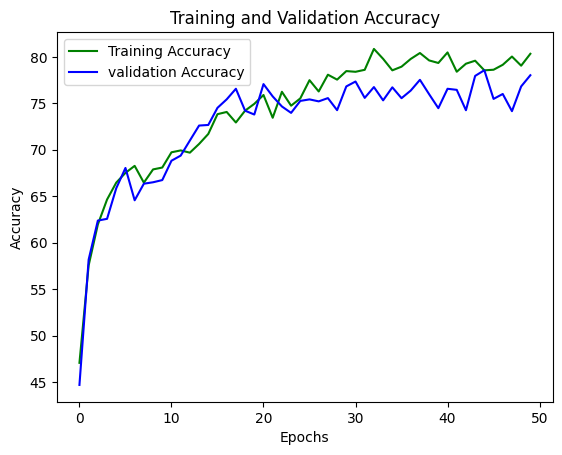

In [162]:
epochs = range(50)
plt.plot(epochs, train_acc, 'g', label='Training Accuracy')
plt.plot(epochs, valid_acc, 'b', label='validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Show the curve of training and validation loss

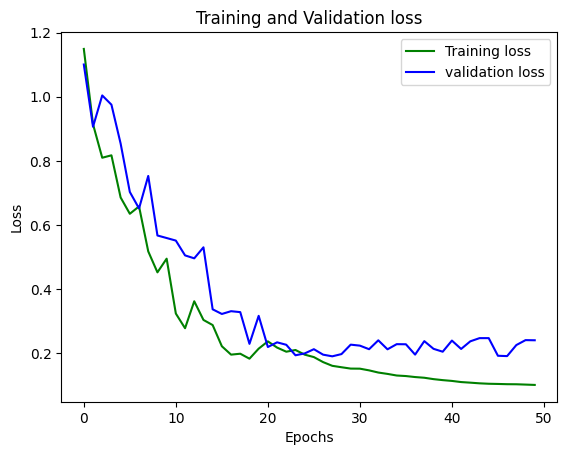

In [178]:
plt.plot(epochs, train_losses, 'g', label='Training loss')
plt.plot(epochs, valid_losses, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()